In [4]:
import numpy as np, pandas as pd
from McL import *
from collections import Counter
import pickle
import seaborn as sns

from sklearn.model_selection import train_test_split

train_file_name = '../conan/train.csv'
test_file_name = '../conan/test.csv'

with open(f'{train_file_name}.pickle', 'rb') as handle:
    data_transformation = pickle.load(handle)
    mapping_train = {data_transformation['id'][i]:np.array(data_transformation['values'][i]) for i in range(len(data_transformation['id']))}

with open(f'{test_file_name}.pickle', 'rb') as handle:
	data_transformation = pickle.load(handle)
	mapping_test = {data_transformation['id'][i]:np.array(data_transformation['values'][i]) for i in range(len(data_transformation['id']))}

train = pd.read_csv(train_file_name, sep=',')
test = pd.read_csv(test_file_name, sep=',')
# drop rows with empty text
train = train.dropna(subset=['text'])
test = test.dropna(subset=['text'])
# get the largest element in text

train['slen'] = train['text'].map(lambda x: len(x))
# train = train.sort_values(by=['slen'], ascending=True)[:-100]
class_map = {c:i for i, c in enumerate(Counter(train['Class']).keys())}
print(class_map)

model = SeqModel(interm_size = 128,  classes_len = len(Counter(train['Class']).keys()))
model.load("../conan/Mc+L.pt")



devloader = DataLoader(Data(test, mapping_test, class_map), 
                       batch_size=8, shuffle=False, 
                       num_workers=4, worker_init_fn=seed_worker)
itera = tqdm(enumerate(devloader, 0), total = len(devloader))


runing_stats = {'out':None, 'label':None, 'text':None, 'id':None, 'mask':None}
model.eval()
print(evaluate(model, task = 'Class', data_dev = test, bs = 8, 
                                mapping_feat = {'train': mapping_train, 'test' : mapping_test},
                                  class_map = class_map))

with torch.no_grad():
  
  for j, batch in itera:

    torch.cuda.empty_cache()            
    outputs = model(batch, get_mask = True)

    runing_stats['out'] = outputs[0].detach().cpu() if runing_stats['out'] is None else  torch.cat((runing_stats['out'], outputs[0].detach().cpu()), dim=0)
    runing_stats['label'] = batch['Class']  if runing_stats['label'] is None else torch.cat((runing_stats['label'], batch['Class']), dim=0)
    runing_stats['text'] = batch['text']  if runing_stats['text'] is None else runing_stats['text'] + batch['text']
    runing_stats['id'] = list(batch['id'])  if runing_stats['id'] is None else runing_stats['id'] + list(batch['id'])
    runing_stats['mask'] = outputs[1].detach().cpu() if runing_stats['mask'] is None else torch.cat((runing_stats['mask'], outputs[1].detach().cpu()), dim=0)
runing_stats['out'] = torch.nn.functional.softmax(runing_stats['out'], dim=-1)
runing_stats['y_hat'] = runing_stats['out'].max(dim=-1).indices.numpy()
# %%

class_map = {"noncounter": 0, "counterspeech": 1}

df = pd.read_csv("../adjectives_sortd_en.csv")
special_tokens = df['adjective'].tolist() 

{'facts': 0, 'support': 1, 'denouncing': 2, 'hypocrisy': 3, 'unrelated': 4, 'humor': 5, 'question': 6}
Weights Loaded


 34%|███▍      | 26/77 [00:00<00:00, 71.69it/s]

0.6084381561529355


100%|██████████| 77/77 [00:00<00:00, 87.45it/s] 


In [6]:
import numpy as np, pandas as pd
from Mc import *
from collections import Counter
import pickle
import seaborn as sns

from sklearn.model_selection import train_test_split


# _ = train_model_dev(data_train=train, data_dev=test, epoches=30, batch_size=128,
# 				interm_layer_size = 128, lr = 2e-3,  decay=1e-6, output='.', task='Class', 
# 				classes_len = len(Counter(train['Class']).keys()), output_name = f"tsnh_mc",
# 				mapping_feat = {'train': mapping_train, 'test' : mapping_train},
# 				class_map = class_map, feature_mask = list(range(244)), verbose = True)

model = SeqModel(interm_size = 128,  classes_len = len(Counter(train['Class']).keys()), 
                 feature_size=244)
model.load(f"tsnh_mc.pt")


devloader = DataLoader(Data(test, mapping_train, class_map), 
                       batch_size=8, shuffle=False, 
                       num_workers=4, worker_init_fn=seed_worker)
itera = tqdm(enumerate(devloader, 0), total = len(devloader))


runing_stats_original = {'out':None, 'label':None, 'text':None, 'id':None, 'mask':None}
model.eval()
print(evaluate(model, task = 'Class', data_dev = test, bs = 8, 
                                mapping_feat = {'train': mapping_train, 'test' : mapping_train},
                                  class_map = class_map))

with torch.no_grad():
  
  for j, batch in itera:

    torch.cuda.empty_cache()            
    outputs = model(batch, get_mask = True)

    runing_stats_original['out'] = outputs[0].detach().cpu() if runing_stats_original['out'] is None else  torch.cat((runing_stats_original['out'], outputs[0].detach().cpu()), dim=0)
    runing_stats_original['label'] = batch['Class']  if runing_stats_original['label'] is None else torch.cat((runing_stats_original['label'], batch['Class']), dim=0)
    runing_stats_original['text'] = batch['text']  if runing_stats_original['text'] is None else runing_stats_original['text'] + batch['text']
    runing_stats_original['id'] = batch['id']  if runing_stats_original['id'] is None else runing_stats_original['id'] + batch['id']
    runing_stats_original['mask'] = outputs[1].detach().cpu() if runing_stats_original['mask'] is None else torch.cat((runing_stats_original['mask'], outputs[1].detach().cpu()), dim=0)
runing_stats_original['out'] = torch.nn.functional.softmax(runing_stats_original['out'], dim=-1)
runing_stats_original['y_hat'] = runing_stats_original['out'].max(dim=-1).indices.numpy()
# %%

Weights Loaded


  6%|▌         | 21/346 [00:01<00:21, 15.08it/s]

0.7319832909862907


100%|██████████| 346/346 [00:04<00:00, 71.97it/s] 


In [7]:
studied_class = "counterspeech"
layer_output = class_map[studied_class]
correctly_predicted_cs = sorted([(runing_stats['out'][i][layer_output].item(), i) for i in range(len(runing_stats['out'])) if runing_stats['label'][i] == layer_output and runing_stats['y_hat'][i] == layer_output])


# for i in range(10):#len(correctly_predicted_cs)):


    # indexx = correctly_predicted_cs[-i][1]

    # if runing_stats['id'][indexx].item() not in [487, 643, 204]:
    #     continue
    
    # print(f"Correctly predicted {studied_class}: {runing_stats['id'][indexx]} ")
    # print(f"Probability: {correctly_predicted_cs[-i][0]}")
    # print(f"A: {runing_stats['text'][indexx]}")

    # top_10_features = (runing_stats['mask'][indexx]*mapping_train[runing_stats['id'][indexx]]).argsort(descending=True)[:10]
    # print("Top 10 features")
    # for j in top_10_features:
    #     print(special_tokens[j.item()] + "\t")#, f"{runing_stats['mask'][indexx][j.item()].item():.3f}",f"{mapping_test[runing_stats['id'][indexx].item()][j.item()]:.3f}" )

In [8]:
studied_class = "noncounter"
layer_output = class_map[studied_class]
correctly_predicted_non_cs = sorted([(runing_stats['out'][i][layer_output].item(), i) for i in range(len(runing_stats['out'])) if runing_stats['label'][i] == layer_output and runing_stats['y_hat'][i] == layer_output])

In [25]:
runing_stats['id'][int(indexx[10])]

'UgihF4NcroPK13gCoAEC'

In [ ]:
k = len(correctly_predicted_cs)
indexx = np.array(correctly_predicted_cs[:-k:-1])[:,1]
top_k_features_cs = runing_stats['mask'][indexx]
top_k_features_cs_original = runing_stats_original['mask'][indexx]

for i in range(k -1):
    top_k_features_cs[i] = top_k_features_cs[i]*mapping_train[runing_stats['id'][int(indexx[i])]]
    top_k_features_cs_original[i] = top_k_features_cs_original[i]*mapping_train[runing_stats['id'][int(indexx[i])]]


/tmp/ipykernel_8081/1462983999.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  top_k_features_cs[i] = top_k_features_cs[i]*mapping_train[runing_stats['id'][int(indexx[i])]]
/tmp/ipykernel_8081/1462983999.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  top_k_features_cs_original[i] = top_k_features_cs_original[i]*mapping_train[runing_stats_original['id'][int(indexx[i])]]


In [ ]:
special_tokens[j.item()]

#### save top features in json

In [ ]:
json_list = []

for i in range(100):
    
	#top feature indices for regularized model
	tfirm = top_k_features_cs[i].argsort(descending=True)[:10]
	#top feature indices for original model
	tfiom = top_k_features_cs_original[i].argsort(descending=True)[:10]

	item = {'text': runing_stats['text'][int(indexx[i])],
		 	'regularized': [(special_tokens[k.item()], f"{top_k_features_cs[i][k.item()].item():.5f}") for k in tfirm],
			'original': [(special_tokens[k.item()], f"{top_k_features_cs_original[i][k.item()].item():.5f}") for k in tfiom]
		 }
	json_list += [item]
#save list as json

import json
with open('top_features.json', 'w') as outfile:
	json.dump(json_list, outfile, indent=4)

#### save top features in csv

In [ ]:
dataframe = {'text': []}
for i in range(10):
    dataframe[f"adjective_{i + 1}"] = []
    dataframe[f"value_{i + 1}"] = []

def normalize_values(values):

	z = sum(values)
	return [v/(z + 1e-9) for v in values]

for i in range(100):
    
	#top feature indices for regularized model
	tfirm = top_k_features_cs[i].argsort(descending=True)[:10]
	#top feature indices for original model
	tfiom = top_k_features_cs_original[i].argsort(descending=True)[:10]

	dataframe['text'] += [runing_stats['text'][int(indexx[i])], '']
	tmp = []
	for idxx, k in enumerate(tfirm):
		dataframe[f"adjective_{idxx + 1}"] += [special_tokens[k.item()]]
		tmp += [top_k_features_cs[i][k.item()].item()]
	
	tmp = normalize_values(tmp)
	for idxx, k in enumerate(tmp):
		dataframe[f"value_{idxx + 1}"] += [k]
	
	tmp = []
	for idxx, k in enumerate(tfiom):
		dataframe[f"adjective_{idxx + 1}"] += [special_tokens[k.item()]]
		tmp += [top_k_features_cs_original[i][k.item()].item()]

	tmp = normalize_values(tmp)
	for idxx, k in enumerate(tmp):
		dataframe[f"value_{idxx + 1}"] += [k]

dataframe = pd.DataFrame(dataframe)
dataframe.to_csv('top_features.csv', index=False)

In [61]:
import pandas as pd

# -------------------------------------------------------------------------
# 1 · Load the data
# -------------------------------------------------------------------------
# Option A – from a CSV file
df = pd.read_csv("top_features.csv")

# Option B – inline string (paste your snippet)
# import io, textwrap
# csv_text = textwrap.dedent("""<paste CSV here>""")
# df = pd.read_csv(io.StringIO(csv_text))

# -------------------------------------------------------------------------
# 2 · Define a row-wise styling function
# -------------------------------------------------------------------------
def style_adjectives(row):
    """Return a list of per-cell CSS rules for this row."""
    css = [''] * len(row)
    for n in range(1, 11):                # adjective_1 … adjective_10
        adj, val = f"adjective_{n}", f"value_{n}"
        if adj in row and val in row:
            alpha = float(row[val])       # 0–1
            css[df.columns.get_loc(adj)] = f"background-color: rgba(255, 0, 0, {alpha:.3f});"
    return css

# -------------------------------------------------------------------------
# 3 · Build a Styler, hide value columns, export to HTML
# -------------------------------------------------------------------------
value_cols = [f"value_{n}" for n in range(1, 11)]

html_str = (
    df.style
      .apply(style_adjectives, axis=1)
    #   .hide_columns(value_cols)        # <-- this works back to 1.3
      # .hide(axis="columns", labels=value_cols)   # modern syntax
      .to_html(doctype_html=True)
)

with open("adjectives_colored.html", "w", encoding="utf-8") as f:
    f.write(html_str)

print("✓ adjectives_colored.html written")

✓ adjectives_colored.html written


In [15]:
k = len(correctly_predicted_non_cs)
indexx = np.array(correctly_predicted_non_cs[:-k:-1])[:,1]
top_k_features_noncs = runing_stats['mask'][indexx]
top_k_features_noncs_original = runing_stats_original['mask'][indexx]

for i in range(k -1):
    top_k_features_noncs[i] = top_k_features_noncs[i]*mapping_train[runing_stats['id'][int(indexx[i])]]
    top_k_features_noncs_original[i] = top_k_features_noncs_original[i]*mapping_train[runing_stats['id'][int(indexx[i])]]


/tmp/ipykernel_8081/2158422539.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  top_k_features_noncs[i] = top_k_features_noncs[i]*mapping_train[runing_stats['id'][int(indexx[i])]]
/tmp/ipykernel_8081/2158422539.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  top_k_features_noncs_original[i] = top_k_features_noncs_original[i]*mapping_train[runing_stats['id'][int(indexx[i])]]


/tmp/ipykernel_8081/2100525783.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


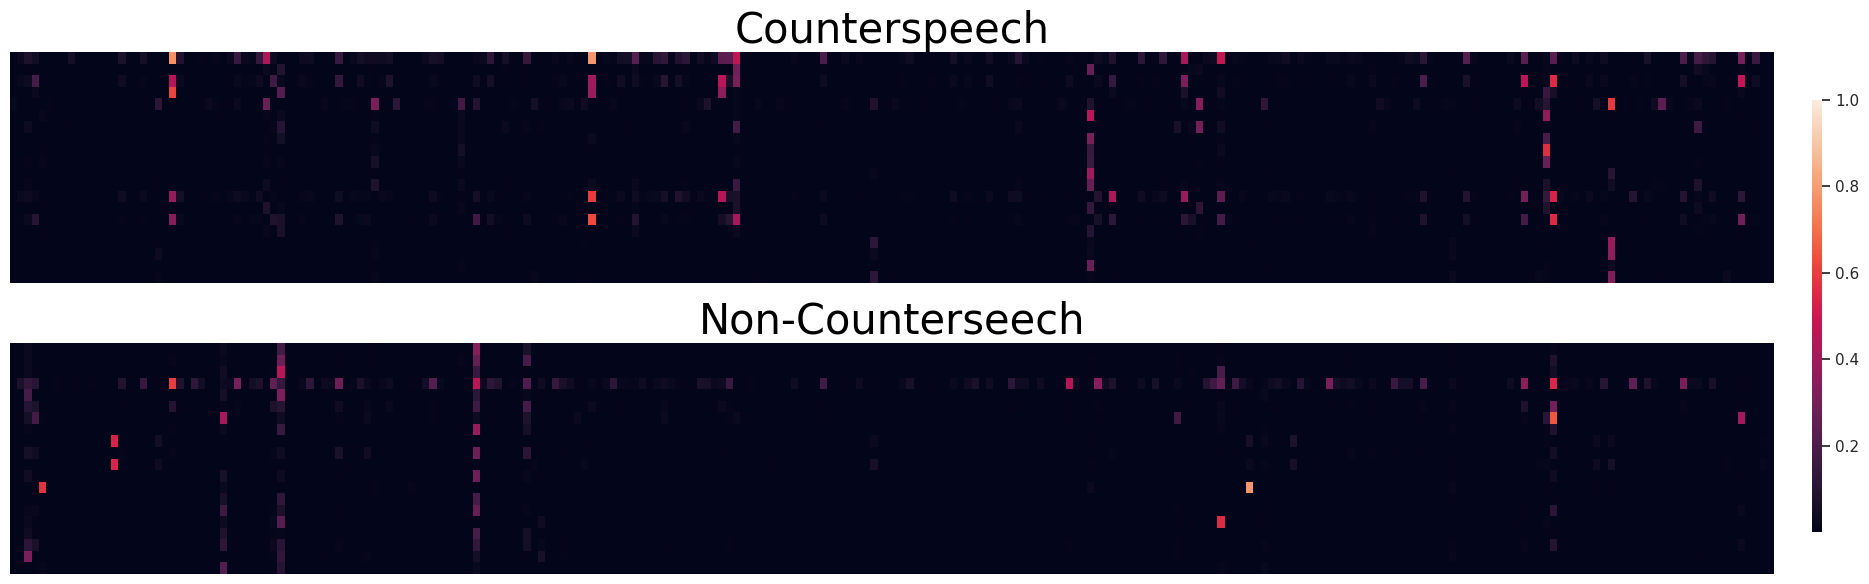

In [16]:
# ploot all heatmaps together for comparison
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2, figsize=(20, 6))
sns.set_theme(style="whitegrid")

cbar_ax = fig.add_axes([.91, .1, .005, .72])

sns.heatmap(top_k_features_cs[:20,:],  ax=axs[0], vmax=1,
            cbar=True, cbar_ax=cbar_ax)
sns.heatmap(top_k_features_noncs[:20,:], ax=axs[1], vmax=1,
            cbar=False, cbar_ax=None)


axs[1].set_yticks([])
axs[1].set_xticks([])
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title("Counterspeech", fontsize=30)
axs[1].set_title("Non-Counterseech", fontsize=30)
fig.tight_layout(rect=[0, 0, .9, 1])

plt.savefig('tsnh_masks_reg.pdf', dpi=500, bbox_inches='tight')
plt.show()


/tmp/ipykernel_8081/2739497352.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


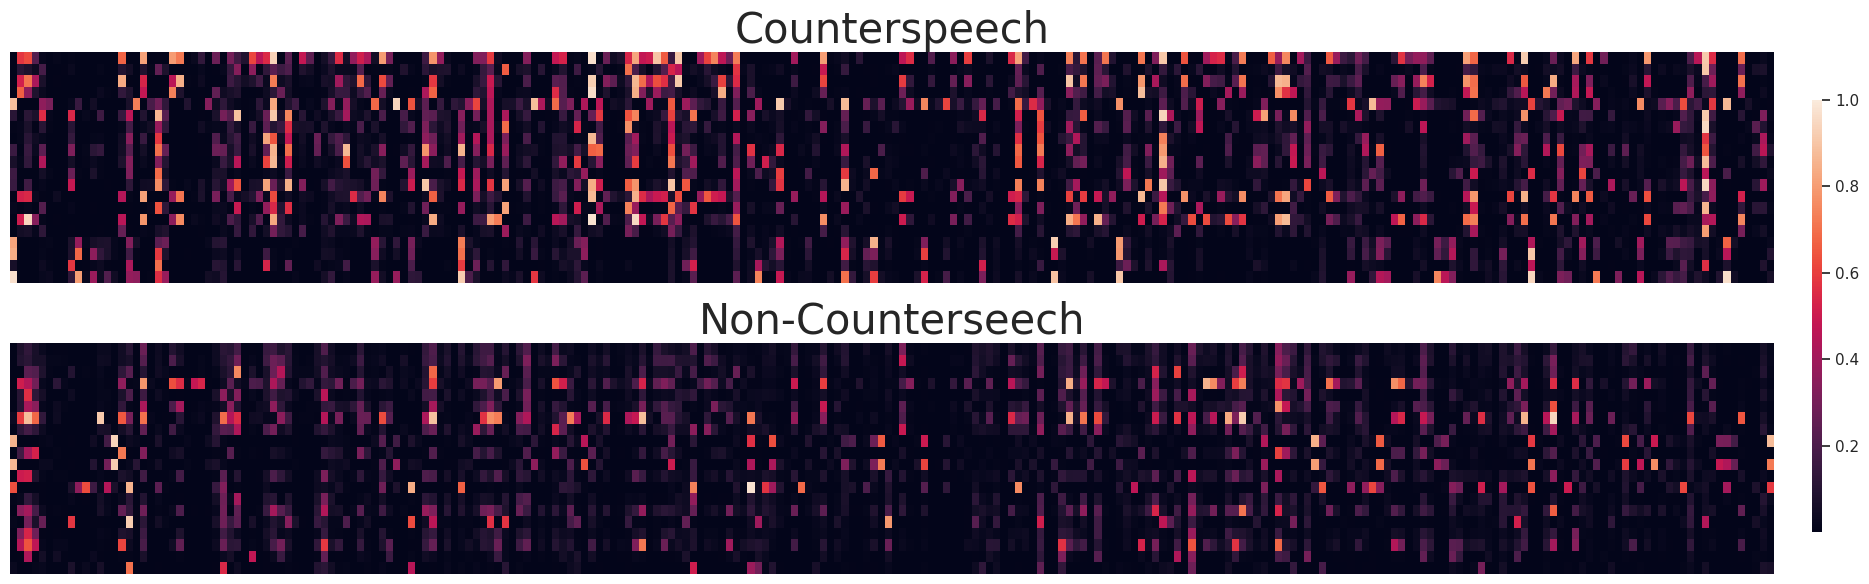

In [24]:
# ploot all heatmaps together for comparison
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2, figsize=(20, 6))
sns.set_theme(style="whitegrid")

cbar_ax = fig.add_axes([.91, .1, .005, .72])

sns.heatmap(top_k_features_cs_original[:20,:],  ax=axs[0], vmax=1,
            cbar=True, cbar_ax=cbar_ax)
sns.heatmap(top_k_features_noncs_original[:20,:], ax=axs[1], vmax=1,
            cbar=False, cbar_ax=None)


axs[1].set_yticks([])
axs[1].set_xticks([])
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title("Counterspeech", fontsize=30)
axs[1].set_title("Non-Counterseech", fontsize=30)
fig.tight_layout(rect=[0, 0, .9, 1])

plt.savefig('tsnh_masks_no_reg.pdf', dpi=500, bbox_inches='tight')
plt.show()


/tmp/ipykernel_3874264/1167248068.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])
/tmp/ipykernel_3874264/1167248068.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


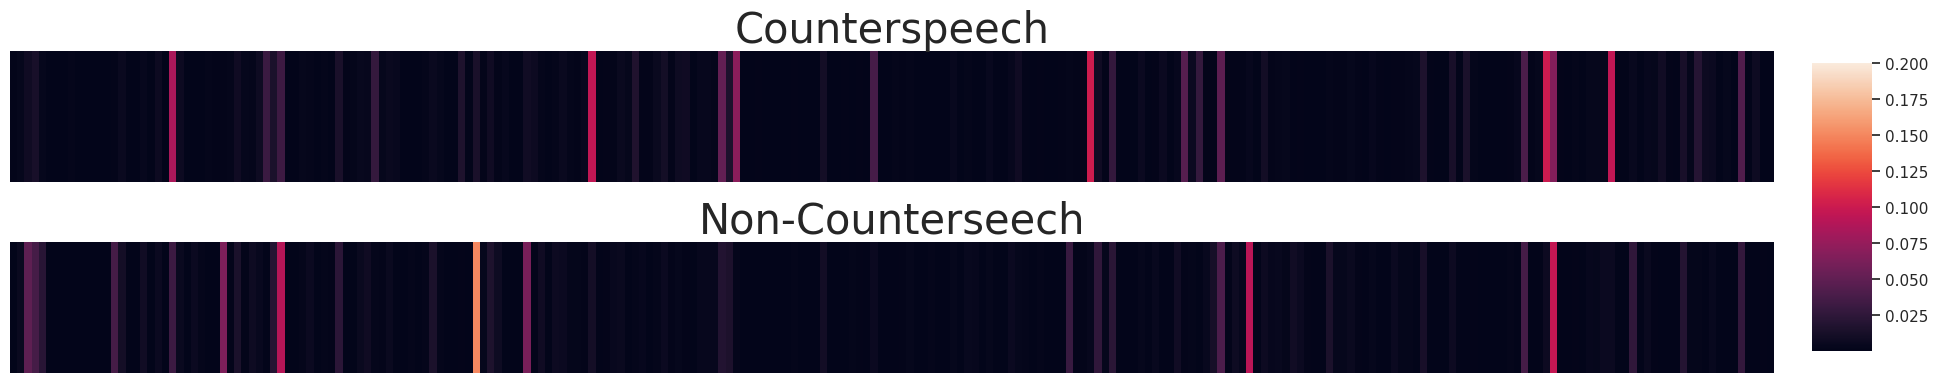

In [24]:
# ploot all heatmaps together for comparison


# plt.rcParams['font.size'] = 24
fig, axs = plt.subplots(2, figsize=(20, 4))
cbar_ax = fig.add_axes([.91, .1, .03, .72])

sns.set_theme(style="whitegrid")
sns.heatmap(top_k_features_cs[:30, :].mean(dim=0, keepdim=True), ax=axs[0], vmax=0.2, 
            cbar=True, cbar_ax=cbar_ax)


sns.heatmap(top_k_features_noncs[:30, :].mean(dim=0, keepdim=True), ax=axs[1], vmax=0.2, 
            cbar_ax=None, cbar=False)

axs[1].set_yticks([])
axs[1].set_xticks([])
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title("Counterspeech", fontsize=30)
axs[1].set_title("Non-Counterseech", fontsize=30)
fig.tight_layout(rect=[0, 0, .9, 1])

fig.tight_layout(rect=[0, 0, .9, 1])
plt.savefig('tsnh_masks_reg_mean.pdf', dpi=500, bbox_inches='tight')
plt.show()


/tmp/ipykernel_3874264/1790691788.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])
/tmp/ipykernel_3874264/1790691788.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


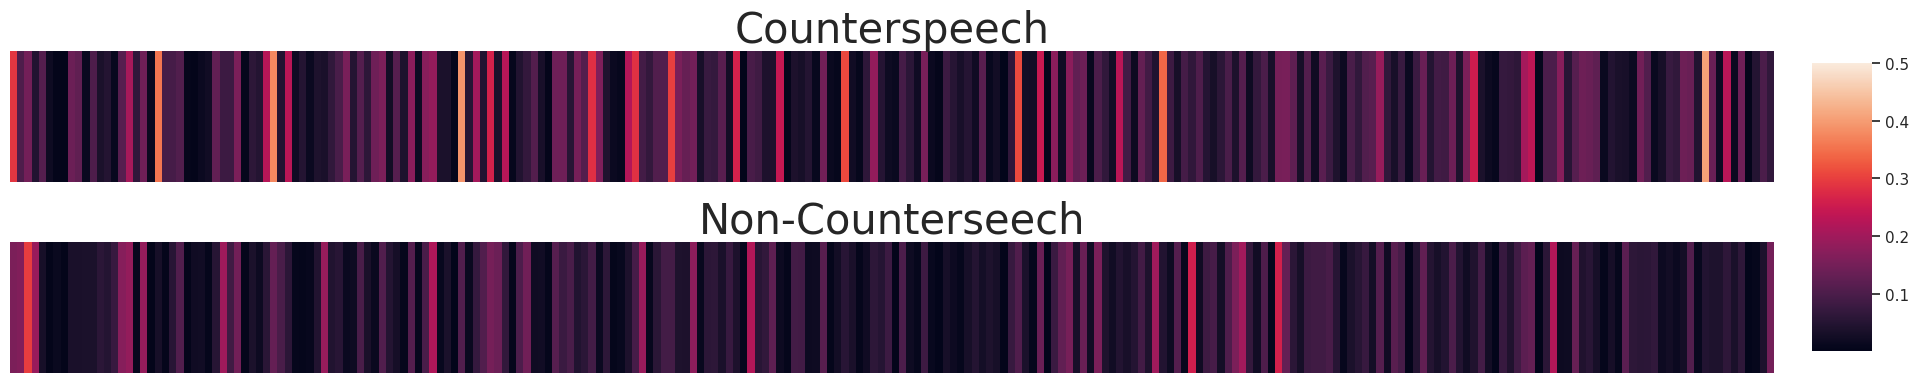

In [25]:
# ploot all heatmaps together for comparison


# plt.rcParams['font.size'] = 24
fig, axs = plt.subplots(2, figsize=(20, 4))
cbar_ax = fig.add_axes([.91, .1, .03, .72])

sns.set_theme(style="whitegrid")
sns.heatmap(top_k_features_cs_original[:30, :].mean(dim=0, keepdim=True), ax=axs[0], vmax=0.5, 
            cbar=True, cbar_ax=cbar_ax)


sns.heatmap(top_k_features_noncs_original[:30, :].mean(dim=0, keepdim=True), ax=axs[1], vmax=0.5, 
            cbar_ax=None, cbar=False)

axs[1].set_yticks([])
axs[1].set_xticks([])
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title("Counterspeech", fontsize=30)
axs[1].set_title("Non-Counterseech", fontsize=30)
fig.tight_layout(rect=[0, 0, .9, 1])

fig.tight_layout(rect=[0, 0, .9, 1])
plt.savefig('tsnh_masks_no_reg_mean.pdf', dpi=500, bbox_inches='tight')
plt.show()


In [8]:
special_tokens[:10]

['abusive',
 'accepting',
 'accommodating',
 'admiring',
 'age discriminatory',
 'aggressive',
 'amused',
 'amusing',
 'annoyed',
 'anti-disabled']

# Germeval

In [42]:
import numpy as np, pandas as pd
from McL import *
from collections import Counter
import pickle
import seaborn as sns

import numpy as np, pandas as pd
import pickle
import seaborn as sns

train_file_name = '../germeval/train.csv'
test_file_name = '../germeval/test.csv'

with open(f'{train_file_name}.pickle', 'rb') as handle:
    data_transformation = pickle.load(handle)
    mapping_train = {data_transformation['id'][i]:np.array(data_transformation['values'][i]) for i in range(len(data_transformation['id']))}


with open(f'{test_file_name}.pickle', 'rb') as handle:
    data_transformation = pickle.load(handle)
    mapping_test = {data_transformation['id'][i]:np.array(data_transformation['values'][i]) for i in range(len(data_transformation['id']))}

test = pd.read_csv(test_file_name, sep=',')
train = pd.read_csv(train_file_name, sep=',')

class_map = {c:i for i, c in enumerate(Counter(train['Class']).keys())}
print(class_map)

_ = train_model_dev(data_train=train, data_dev=test, epoches=30, batch_size=128,
				interm_layer_size = 128, lr = 2e-3,  decay=1e-6, output='.', task='Class', 
				classes_len = len(Counter(train['Class']).keys()), output_name = f"germeval_mc+l",
				mapping_feat = {'train': mapping_train, 'test' : mapping_test},
				class_map = class_map)


model = SeqModel(interm_size = 128,  classes_len = len(Counter(train['Class']).keys()))
model.load(f"germeval_mc+l.pt")


devloader = DataLoader(Data(test, mapping_test, class_map), 
                       batch_size=8, shuffle=False, 
                       num_workers=4, worker_init_fn=seed_worker)
itera = tqdm(enumerate(devloader, 0), total = len(devloader))


runing_stats = {'out':None, 'label':None, 'text':None, 'id':None, 'mask':None}
model.eval()
print(evaluate(model, task = 'Class', data_dev = test, bs = 8, 
                                mapping_feat = {'train': mapping_train, 'test' : mapping_test},
                                  class_map = class_map))

with torch.no_grad():
  
  for j, batch in itera:

    torch.cuda.empty_cache()            
    outputs = model(batch, get_mask = True)

    runing_stats['out'] = outputs[0].detach().cpu() if runing_stats['out'] is None else  torch.cat((runing_stats['out'], outputs[0].detach().cpu()), dim=0)
    runing_stats['label'] = batch['Class']  if runing_stats['label'] is None else torch.cat((runing_stats['label'], batch['Class']), dim=0)
    runing_stats['text'] = batch['text']  if runing_stats['text'] is None else runing_stats['text'] + batch['text']
    runing_stats['id'] = batch['id']  if runing_stats['id'] is None else torch.cat((runing_stats['id'], batch['id']), dim=0)
    runing_stats['mask'] = outputs[1].detach().cpu() if runing_stats['mask'] is None else torch.cat((runing_stats['mask'], outputs[1].detach().cpu()), dim=0)
runing_stats['out'] = torch.nn.functional.softmax(runing_stats['out'], dim=-1)
runing_stats['y_hat'] = runing_stats['out'].max(dim=-1).indices.numpy()
# %%

df = pd.read_csv("../adjectives_sortd_en.csv")
special_tokens = df['adjective'].tolist() 

{0: 0, 1: 1}
SeqModel(
  (normalize_features): LayerNorm((244,), eps=1e-05, elementwise_affine=True)
  (relevance_gate): Sequential(
    (0): Linear(in_features=244, out_features=244, bias=True)
    (1): Sigmoid()
  )
  (intermediate_plus): Sequential(
    (0): Linear(in_features=244, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (classifier_plus): Linear(in_features=64, out_features=2, bias=True)
  (loss_criterion): LossFunction(
    (loss): CrossEntropyLoss()
  )
)


Epoch:  29: 100%|██████████| 40/40 [00:01<00:00, 29.31it/s, loss:0.358 measure:0.802 masks_l2:0.004 dev_loss:0.511 dev_measure: 0.748]

Weights Loaded



/workspaces/counterspeech/code/features_sensitivity/McL.py:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path, map_location=self.device

0.7822563829189264


100%|██████████| 442/442 [00:02<00:00, 149.24it/s]


In [43]:
import numpy as np, pandas as pd
from Mc import *
from collections import Counter
import pickle
import seaborn as sns

from sklearn.model_selection import train_test_split


# _ = train_model_dev(data_train=train, data_dev=test, epoches=30, batch_size=128,
# 				interm_layer_size = 128, lr = 2e-3,  decay=1e-6, output='.', task='Class', 
# 				classes_len = len(Counter(train['Class']).keys()), output_name = f"hscs_mc",
# 				mapping_feat = {'train': mapping_train, 'test' : mapping_test},
# 				class_map = class_map, feature_mask = list(range(244)), verbose = True)

model = SeqModel(interm_size = 128,  classes_len = len(Counter(train['Class']).keys()), 
                 feature_size=244)
model.load(f"germeval_mc.pt")


devloader = DataLoader(Data(test, mapping_test, class_map), 
                       batch_size=8, shuffle=False, 
                       num_workers=4, worker_init_fn=seed_worker)
itera = tqdm(enumerate(devloader, 0), total = len(devloader))


runing_stats_original = {'out':None, 'label':None, 'text':None, 'id':None, 'mask':None}
model.eval()
print(evaluate(model, task = 'Class', data_dev = test, bs = 8, 
                                mapping_feat = {'train': mapping_train, 'test' : mapping_test},
                                  class_map = class_map))

with torch.no_grad():
  
  for j, batch in itera:

    torch.cuda.empty_cache()            
    outputs = model(batch, get_mask = True)

    runing_stats_original['out'] = outputs[0].detach().cpu() if runing_stats_original['out'] is None else  torch.cat((runing_stats_original['out'], outputs[0].detach().cpu()), dim=0)
    runing_stats_original['label'] = batch['Class']  if runing_stats_original['label'] is None else torch.cat((runing_stats_original['label'], batch['Class']), dim=0)
    runing_stats_original['text'] = batch['text']  if runing_stats_original['text'] is None else runing_stats_original['text'] + batch['text']
    runing_stats_original['id'] = batch['id']  if runing_stats_original['id'] is None else torch.cat((runing_stats_original['id'], batch['id']), dim=0)
    runing_stats_original['mask'] = outputs[1].detach().cpu() if runing_stats_original['mask'] is None else torch.cat((runing_stats_original['mask'], outputs[1].detach().cpu()), dim=0)
runing_stats_original['out'] = torch.nn.functional.softmax(runing_stats_original['out'], dim=-1)
runing_stats_original['y_hat'] = runing_stats_original['out'].max(dim=-1).indices.numpy()
# %%

Weights Loaded


  9%|▉         | 40/442 [00:01<00:08, 49.79it/s]

0.7835946469573568


100%|██████████| 442/442 [00:02<00:00, 193.13it/s]


In [44]:
class_map = {"non-offensive": 0, "offensive": 1}

studied_class = "offensive"
layer_output = class_map[studied_class]
correctly_predicted_cs = sorted([(runing_stats['out'][i][layer_output].item(), i) for i in range(len(runing_stats['out'])) if runing_stats['label'][i] == layer_output and runing_stats['y_hat'][i] == layer_output])

studied_class = "non-offensive"
layer_output = class_map[studied_class]
correctly_predicted_hs = sorted([(runing_stats['out'][i][layer_output].item(), i) for i in range(len(runing_stats['out'])) if runing_stats['label'][i] == layer_output and runing_stats['y_hat'][i] == layer_output])


In [54]:
k = len(correctly_predicted_cs)
indexx = np.array(correctly_predicted_cs[:-k:-1])[:,1]
top_k_features_cs = runing_stats['mask'][indexx]
top_k_features_cs_original = runing_stats_original['mask'][indexx]


for i in range(k -1):
    top_k_features_cs[i] = top_k_features_cs[i]*mapping_test[runing_stats['id'][int(indexx[i].item())].item()]
    top_k_features_cs_original[i] = top_k_features_cs_original[i]*mapping_test[runing_stats['id'][int(indexx[i].item())].item()]

/tmp/ipykernel_3966510/3444527339.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  top_k_features_cs[i] = top_k_features_cs[i]*mapping_test[runing_stats['id'][int(indexx[i].item())].item()]
/tmp/ipykernel_3966510/3444527339.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  top_k_features_cs_original[i] = top_k_features_cs_original[i]*mapping_test[runing_stats['id'][int(indexx[i].item())].item()]


In [55]:
k = len(correctly_predicted_hs)
indexx = np.array(correctly_predicted_hs[:-k:-1])[:,1]
top_k_features_hs = runing_stats['mask'][indexx]
top_k_features_hs_original = runing_stats_original['mask'][indexx]

for i in range(k -1):
	top_k_features_hs[i] = top_k_features_hs[i]*mapping_test[runing_stats['id'][int(indexx[i].item())].item()]
	top_k_features_hs_original[i] = top_k_features_hs_original[i]*mapping_test[runing_stats['id'][int(indexx[i].item())].item()]

/tmp/ipykernel_3966510/2094206317.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  top_k_features_hs[i] = top_k_features_hs[i]*mapping_test[runing_stats['id'][int(indexx[i].item())].item()]
/tmp/ipykernel_3966510/2094206317.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  top_k_features_hs_original[i] = top_k_features_hs_original[i]*mapping_test[runing_stats['id'][int(indexx[i].item())].item()]


/tmp/ipykernel_3966510/129511657.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


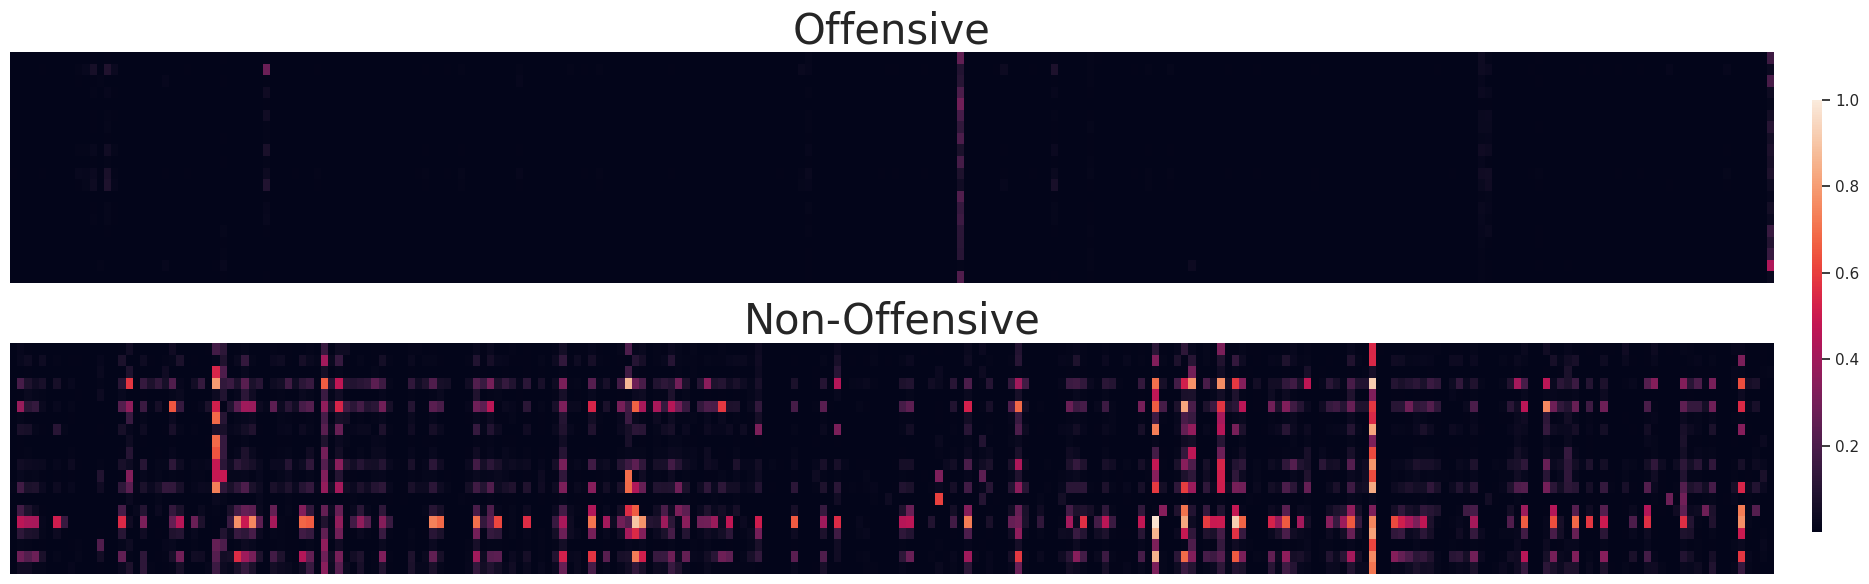

In [57]:
# ploot all heatmaps together for comparison
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2, figsize=(20, 6))
sns.set_theme(style="whitegrid")

cbar_ax = fig.add_axes([.91, .1, .005, .72])

sns.heatmap(top_k_features_cs[:20,:],  ax=axs[0], vmax=1,
            cbar=True, cbar_ax=cbar_ax)
sns.heatmap(top_k_features_hs[:20,:], ax=axs[1], vmax=1,
            cbar=False, cbar_ax=None)


axs[1].set_yticks([])
axs[1].set_xticks([])
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title("Offensive", fontsize=30)
axs[1].set_title("Non-Offensive", fontsize=30)
fig.tight_layout(rect=[0, 0, .9, 1])

plt.savefig('germeval_masks_reg.pdf', dpi=500, bbox_inches='tight')
plt.show()


/tmp/ipykernel_3966510/2372698451.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


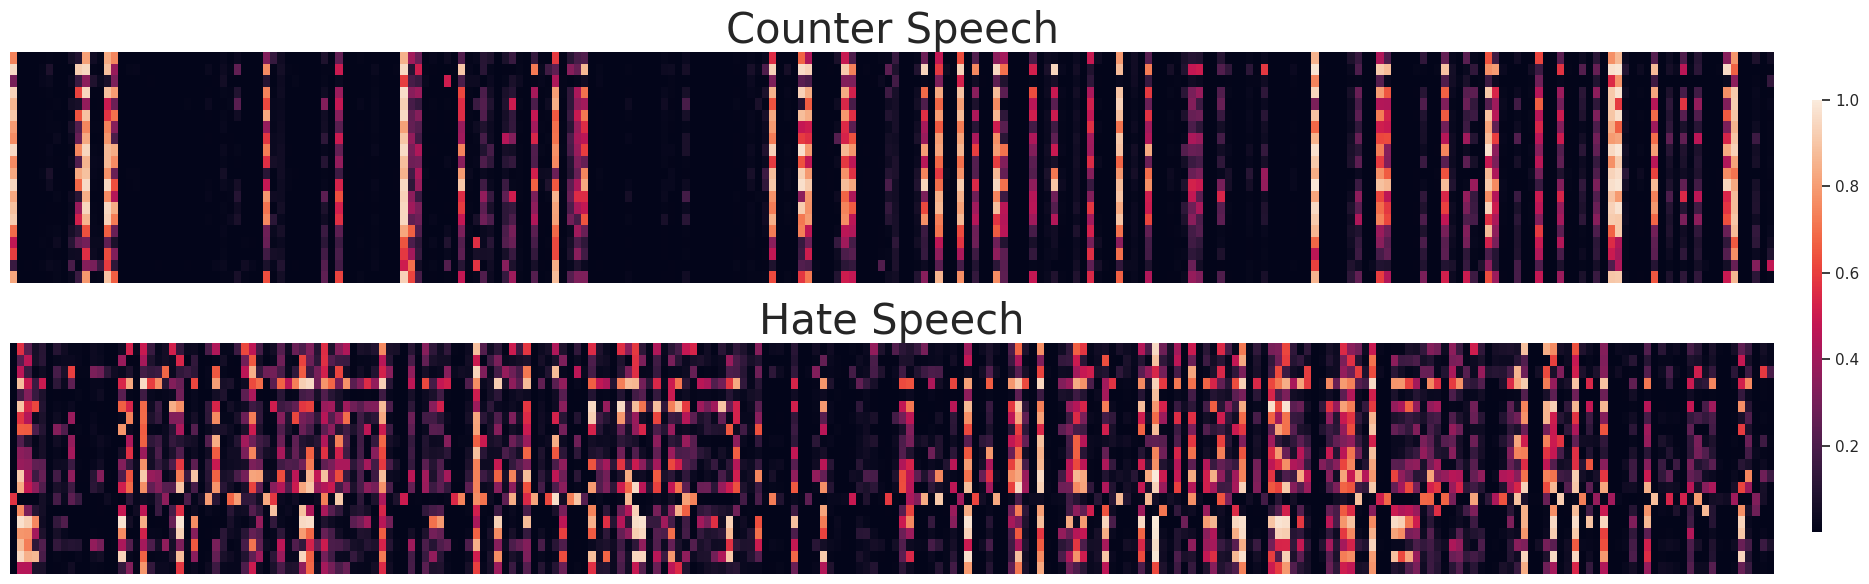

In [60]:
# ploot all heatmaps together for comparison
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2, figsize=(20, 6))
sns.set_theme(style="whitegrid")

cbar_ax = fig.add_axes([.91, .1, .005, .72])

sns.heatmap(top_k_features_cs_original[:20,:],  ax=axs[0], vmax=1,
            cbar=True, cbar_ax=cbar_ax)
sns.heatmap(top_k_features_hs_original[:20,:], ax=axs[1], vmax=1,
            cbar=False, cbar_ax=None)


axs[1].set_yticks([])
axs[1].set_xticks([])
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title("Counter Speech", fontsize=30)
axs[1].set_title("Hate Speech", fontsize=30)
fig.tight_layout(rect=[0, 0, .9, 1])

plt.savefig('germeval_masks_no_reg.pdf', dpi=500, bbox_inches='tight')
plt.show()


# CS/HS

In [63]:
import numpy as np, pandas as pd
from McL import *
from collections import Counter
import pickle
import seaborn as sns

import numpy as np, pandas as pd
import pickle
import seaborn as sns

train_file_name = '../hs_cs/train.csv'
test_file_name = '../hs_cs/test.csv'

with open(f'{train_file_name}.pickle', 'rb') as handle:
    data_transformation = pickle.load(handle)
    mapping_train = {data_transformation['id'][i]:np.array(data_transformation['values'][i]) for i in range(len(data_transformation['id']))}


with open(f'{test_file_name}.pickle', 'rb') as handle:
    data_transformation = pickle.load(handle)
    mapping_test = {data_transformation['id'][i]:np.array(data_transformation['values'][i]) for i in range(len(data_transformation['id']))}

test = pd.read_csv(test_file_name, sep=',')
train = pd.read_csv(train_file_name, sep=',')

class_map = {c:i for i, c in enumerate(Counter(train['Class']).keys())}
print(class_map)

# _ = train_model_dev(data_train=train, data_dev=test, epoches=30, batch_size=128,
# 				interm_layer_size = 128, lr = 2e-3,  decay=1e-6, output='.', task='Class', 
# 				classes_len = len(Counter(train['Class']).keys()), output_name = f"hscs_mc+l",
# 				mapping_feat = {'train': mapping_train, 'test' : mapping_test},
# 				class_map = class_map)


model = SeqModel(interm_size = 128,  classes_len = len(Counter(train['Class']).keys()))
model.load(f"hscs_mc+l.pt")


devloader = DataLoader(Data(test, mapping_test, class_map), 
                       batch_size=8, shuffle=False, 
                       num_workers=4, worker_init_fn=seed_worker)
itera = tqdm(enumerate(devloader, 0), total = len(devloader))


runing_stats = {'out':None, 'label':None, 'text':None, 'id':None, 'mask':None}
model.eval()
print(evaluate(model, task = 'Class', data_dev = test, bs = 8, 
                                mapping_feat = {'train': mapping_train, 'test' : mapping_test},
                                  class_map = class_map))

with torch.no_grad():
  
  for j, batch in itera:

    torch.cuda.empty_cache()            
    outputs = model(batch, get_mask = True)

    runing_stats['out'] = outputs[0].detach().cpu() if runing_stats['out'] is None else  torch.cat((runing_stats['out'], outputs[0].detach().cpu()), dim=0)
    runing_stats['label'] = batch['Class']  if runing_stats['label'] is None else torch.cat((runing_stats['label'], batch['Class']), dim=0)
    runing_stats['text'] = batch['text']  if runing_stats['text'] is None else runing_stats['text'] + batch['text']
    runing_stats['id'] = batch['id']  if runing_stats['id'] is None else torch.cat((runing_stats['id'], batch['id']), dim=0)
    runing_stats['mask'] = outputs[1].detach().cpu() if runing_stats['mask'] is None else torch.cat((runing_stats['mask'], outputs[1].detach().cpu()), dim=0)
runing_stats['out'] = torch.nn.functional.softmax(runing_stats['out'], dim=-1)
runing_stats['y_hat'] = runing_stats['out'].max(dim=-1).indices.numpy()
# %%

df = pd.read_csv("../adjectives_sortd_en.csv")
special_tokens = df['adjective'].tolist() 

{2: 0, 0: 1, 1: 2}
Weights Loaded


/workspaces/counterspeech/code/features_sensitivity/McL.py:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path, map_location=self.device)

0.541358441017758


100%|██████████| 90/90 [00:00<00:00, 91.64it/s] 


In [64]:
import numpy as np, pandas as pd
from Mc import *
from collections import Counter
import pickle
import seaborn as sns

from sklearn.model_selection import train_test_split


# _ = train_model_dev(data_train=train, data_dev=test, epoches=30, batch_size=128,
# 				interm_layer_size = 128, lr = 2e-3,  decay=1e-6, output='.', task='Class', 
# 				classes_len = len(Counter(train['Class']).keys()), output_name = f"hscs_mc",
# 				mapping_feat = {'train': mapping_train, 'test' : mapping_test},
# 				class_map = class_map, feature_mask = list(range(244)), verbose = True)

model = SeqModel(interm_size = 128,  classes_len = len(Counter(train['Class']).keys()), 
                 feature_size=244)
model.load(f"hscs_mc.pt")


devloader = DataLoader(Data(test, mapping_test, class_map), 
                       batch_size=8, shuffle=False, 
                       num_workers=4, worker_init_fn=seed_worker)
itera = tqdm(enumerate(devloader, 0), total = len(devloader))


runing_stats_original = {'out':None, 'label':None, 'text':None, 'id':None, 'mask':None}
model.eval()
print(evaluate(model, task = 'Class', data_dev = test, bs = 8, 
                                mapping_feat = {'train': mapping_train, 'test' : mapping_test},
                                  class_map = class_map))

with torch.no_grad():
  
  for j, batch in itera:

    torch.cuda.empty_cache()            
    outputs = model(batch, get_mask = True)

    runing_stats_original['out'] = outputs[0].detach().cpu() if runing_stats_original['out'] is None else  torch.cat((runing_stats_original['out'], outputs[0].detach().cpu()), dim=0)
    runing_stats_original['label'] = batch['Class']  if runing_stats_original['label'] is None else torch.cat((runing_stats_original['label'], batch['Class']), dim=0)
    runing_stats_original['text'] = batch['text']  if runing_stats_original['text'] is None else runing_stats_original['text'] + batch['text']
    runing_stats_original['id'] = batch['id']  if runing_stats_original['id'] is None else torch.cat((runing_stats_original['id'], batch['id']), dim=0)
    runing_stats_original['mask'] = outputs[1].detach().cpu() if runing_stats_original['mask'] is None else torch.cat((runing_stats_original['mask'], outputs[1].detach().cpu()), dim=0)
runing_stats_original['out'] = torch.nn.functional.softmax(runing_stats_original['out'], dim=-1)
runing_stats_original['y_hat'] = runing_stats_original['out'].max(dim=-1).indices.numpy()
# %%

Weights Loaded


 33%|███▎      | 30/90 [00:00<00:00, 68.94it/s]

0.5903146877339086


100%|██████████| 90/90 [00:00<00:00, 100.43it/s]


In [65]:
class_map = {"neutral": 0, "hate speech": 1, "counter speech": 2}

studied_class = "counter speech"
layer_output = class_map[studied_class]
correctly_predicted_cs = sorted([(runing_stats['out'][i][layer_output].item(), i) for i in range(len(runing_stats['out'])) if runing_stats['label'][i] == layer_output and runing_stats['y_hat'][i] == layer_output])

studied_class = "hate speech"
layer_output = class_map[studied_class]
correctly_predicted_hs = sorted([(runing_stats['out'][i][layer_output].item(), i) for i in range(len(runing_stats['out'])) if runing_stats['label'][i] == layer_output and runing_stats['y_hat'][i] == layer_output])

studied_class = "neutral"
layer_output = class_map[studied_class]
correctly_predicted_n = sorted([(runing_stats['out'][i][layer_output].item(), i) for i in range(len(runing_stats['out'])) if runing_stats['label'][i] == layer_output and runing_stats['y_hat'][i] == layer_output])

In [66]:
k = len(correctly_predicted_cs)
indexx = np.array(correctly_predicted_cs[:-k:-1])[:,1]
top_k_features_cs = runing_stats['mask'][indexx]
top_k_features_cs_original = runing_stats_original['mask'][indexx]


for i in range(k -1):
    top_k_features_cs[i] = top_k_features_cs[i]*mapping_test[runing_stats['id'][int(indexx[i].item())].item()]
    top_k_features_cs_original[i] = top_k_features_cs_original[i]*mapping_test[runing_stats['id'][int(indexx[i].item())].item()]

/tmp/ipykernel_3966510/3444527339.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  top_k_features_cs[i] = top_k_features_cs[i]*mapping_test[runing_stats['id'][int(indexx[i].item())].item()]
/tmp/ipykernel_3966510/3444527339.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  top_k_features_cs_original[i] = top_k_features_cs_original[i]*mapping_test[runing_stats['id'][int(indexx[i].item())].item()]


In [67]:
k = len(correctly_predicted_hs)
indexx = np.array(correctly_predicted_hs[:-k:-1])[:,1]
top_k_features_hs = runing_stats['mask'][indexx]
top_k_features_hs_original = runing_stats_original['mask'][indexx]

for i in range(k -1):
	top_k_features_hs[i] = top_k_features_hs[i]*mapping_test[runing_stats['id'][int(indexx[i].item())].item()]
	top_k_features_hs_original[i] = top_k_features_hs_original[i]*mapping_test[runing_stats['id'][int(indexx[i].item())].item()]

/tmp/ipykernel_3966510/2094206317.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  top_k_features_hs[i] = top_k_features_hs[i]*mapping_test[runing_stats['id'][int(indexx[i].item())].item()]
/tmp/ipykernel_3966510/2094206317.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  top_k_features_hs_original[i] = top_k_features_hs_original[i]*mapping_test[runing_stats['id'][int(indexx[i].item())].item()]


In [68]:
k = len(correctly_predicted_n)
indexx = np.array(correctly_predicted_n[:-k:-1])[:,1]
top_k_features_n = runing_stats['mask'][indexx]
top_k_features_n_original = runing_stats_original['mask'][indexx]

for i in range(k -1):
	top_k_features_n[i] = top_k_features_n[i]*mapping_test[runing_stats['id'][int(indexx[i].item())].item()]
	top_k_features_n_original[i] = top_k_features_n_original[i]*mapping_test[runing_stats['id'][int(indexx[i].item())].item()]
	

/tmp/ipykernel_3966510/3858086182.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  top_k_features_n[i] = top_k_features_n[i]*mapping_test[runing_stats['id'][int(indexx[i].item())].item()]
/tmp/ipykernel_3966510/3858086182.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  top_k_features_n_original[i] = top_k_features_n_original[i]*mapping_test[runing_stats['id'][int(indexx[i].item())].item()]


/tmp/ipykernel_3966510/3849404409.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


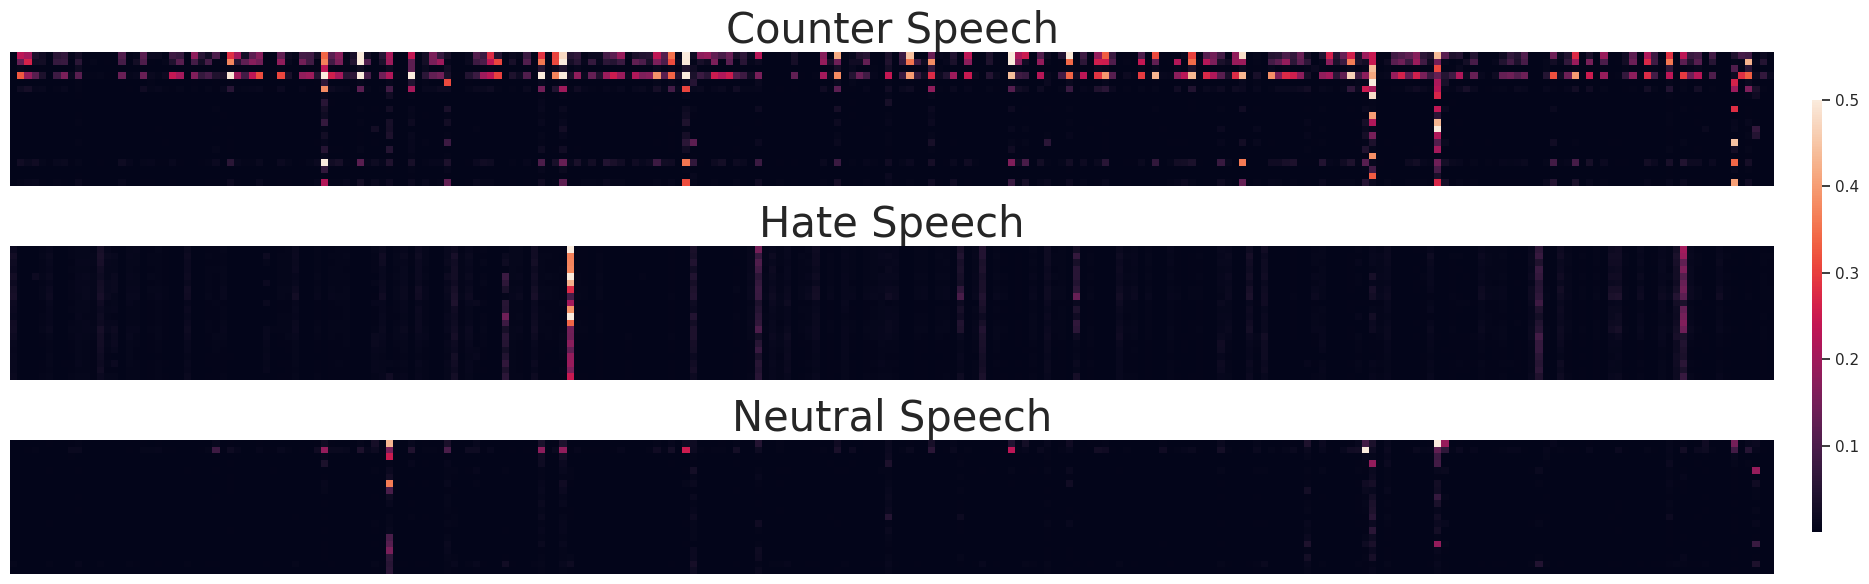

In [72]:
# ploot all heatmaps together for comparison
from matplotlib import pyplot as plt

fig, axs = plt.subplots(3, figsize=(20, 6))
sns.set_theme(style="whitegrid")

cbar_ax = fig.add_axes([.91, .1, .005, .72])

sns.heatmap(top_k_features_cs[:20,:],  ax=axs[0], vmax=0.5,
            cbar=True, cbar_ax=cbar_ax)
sns.heatmap(top_k_features_hs[:20,:], ax=axs[1], vmax=0.25,
            cbar=False, cbar_ax=None)
sns.heatmap(top_k_features_n[:20,:], ax=axs[2], vmax=0.1,
            cbar=False, cbar_ax=None)


axs[1].set_yticks([])
axs[1].set_xticks([])
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[2].set_yticks([])
axs[2].set_xticks([])
axs[0].set_title("Counter Speech", fontsize=30)
axs[1].set_title("Hate Speech", fontsize=30)
axs[2].set_title('Neutral Speech', fontsize=30)
fig.tight_layout(rect=[0, 0, .9, 1])

plt.savefig('hscs_masks_reg.pdf', dpi=500, bbox_inches='tight')
plt.show()


/tmp/ipykernel_3966510/83200026.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


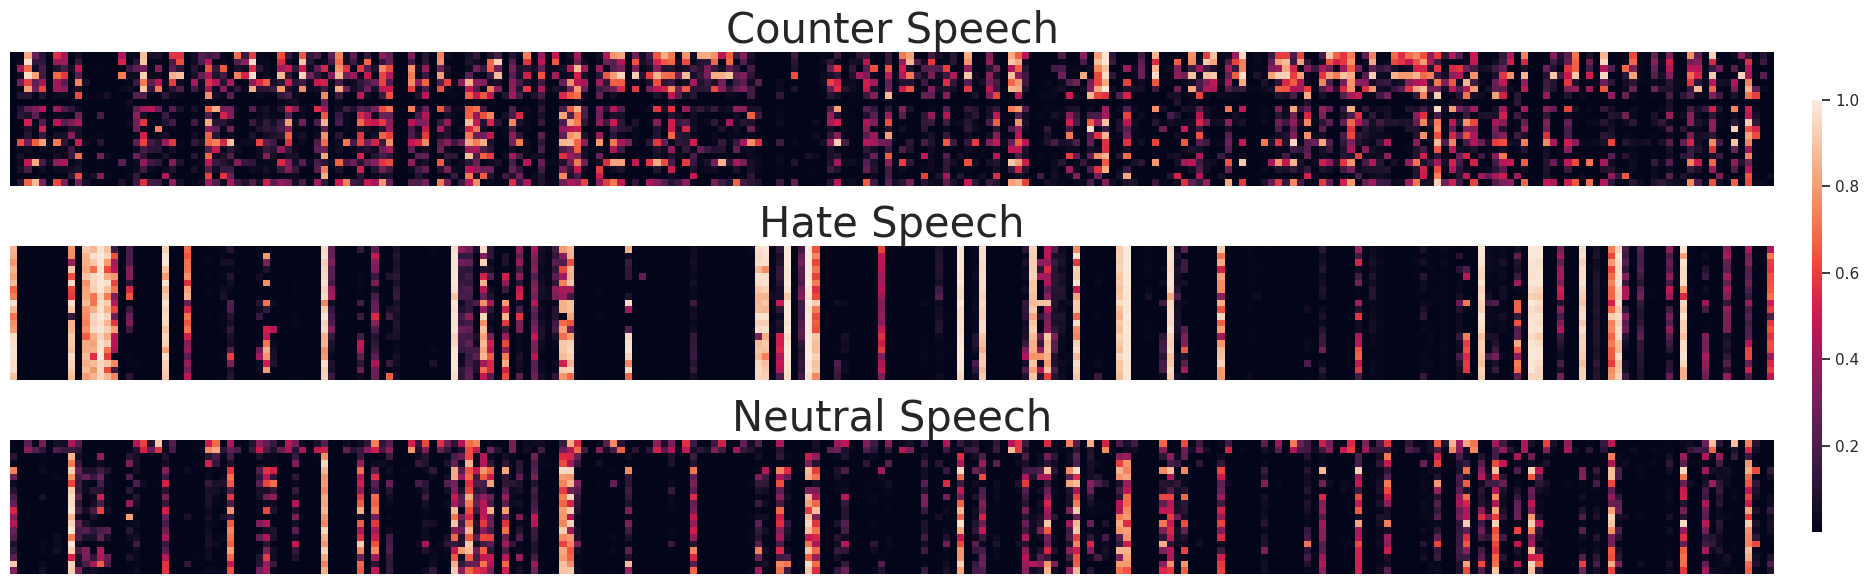

In [36]:
# ploot all heatmaps together for comparison
from matplotlib import pyplot as plt

fig, axs = plt.subplots(3, figsize=(20, 6))
sns.set_theme(style="whitegrid")

cbar_ax = fig.add_axes([.91, .1, .005, .72])

sns.heatmap(top_k_features_cs_original[:20,:],  ax=axs[0], vmax=1,
            cbar=True, cbar_ax=cbar_ax)
sns.heatmap(top_k_features_hs_original[:20,:], ax=axs[1], vmax=1,
            cbar=False, cbar_ax=None)
sns.heatmap(top_k_features_n_original[:20,:], ax=axs[2], vmax=1,
            cbar=False, cbar_ax=None)


axs[1].set_yticks([])
axs[1].set_xticks([])
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[2].set_yticks([])
axs[2].set_xticks([])
axs[0].set_title("Counter Speech", fontsize=30)
axs[1].set_title("Hate Speech", fontsize=30)
axs[2].set_title('Neutral Speech', fontsize=30)
fig.tight_layout(rect=[0, 0, .9, 1])

plt.savefig('hscs_masks_noreg.pdf', dpi=500, bbox_inches='tight')
plt.show()
